In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.stats as stats

Leer database usando Webscrapping

In [3]:
import Scrapping_conmebol as scrap

database = scrap.database
database.sample(7)

,date,World Cup Qualif,Team_home,Team_away,Goals_home,Goals_away
36,1997-04-02,1998,Bolivia,Argentina,2.0,1.0
310,2009-04-01,2010,Chile,Uruguay,0.0,0.0
119,2000-11-15,2002,Paraguay,Peru,5.0,1.0
590,2022-03-29,2022,Venezuela,Colombia,NaN,NaN
53,1997-07-20,1998,Bolivia,Uruguay,1.0,0.0
124,2001-03-28,2002,Ecuador,Brazil,1.0,0.0
495,2017-10-05,2018,Venezuela,Uruguay,0.0,0.0


In [5]:
database.to_csv("conmebol.csv", index=False)

In [5]:
#partidos por jugar
index_na = database[database['Goals_home'].isna()].index
database[database['Goals_home'].isna()]

,date,World Cup Qualif,Team_home,Team_away,Goals_home,Goals_away
539,2021-09-05,2022,Brazil,Argentina,NaN,NaN
584,2022-03-24,2022,Uruguay,Peru,NaN,NaN
585,2022-03-24,2022,Colombia,Bolivia,NaN,NaN
586,2022-03-24,2022,Brazil,Chile,NaN,NaN
587,2022-03-24,2022,Paraguay,Ecuador,NaN,NaN
588,2022-03-25,2022,Argentina,Venezuela,NaN,NaN
589,2022-03-29,2022,Peru,Paraguay,NaN,NaN
590,2022-03-29,2022,Venezuela,Colombia,NaN,NaN
591,2022-03-29,2022,Bolivia,Brazil,NaN,NaN
592,2022-03-29,2022,Chile,Uruguay,NaN,NaN


In [6]:
#Partidos jugados
print(database[~database['Goals_home'].isna()].shape)
df = database[~database['Goals_home'].isna()]
df.sample(5)

(583, 6)


,date,World Cup Qualif,Team_home,Team_away,Goals_home,Goals_away
236,2005-06-08,2006,Argentina,Brazil,3.0,1.0
281,2008-06-19,2010,Venezuela,Chile,2.0,3.0
109,2000-09-03,2002,Uruguay,Ecuador,4.0,0.0
462,2016-10-11,2018,Chile,Peru,2.0,1.0
235,2005-06-08,2006,Paraguay,Bolivia,4.0,1.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 583 entries, 0 to 583
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              583 non-null    datetime64[ns]
 1   World Cup Qualif  583 non-null    int64         
 2   Team_home         583 non-null    object        
 3   Team_away         583 non-null    object        
 4   Goals_home        583 non-null    float64       
 5   Goals_away        583 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 31.9+ KB


Distribución de goles

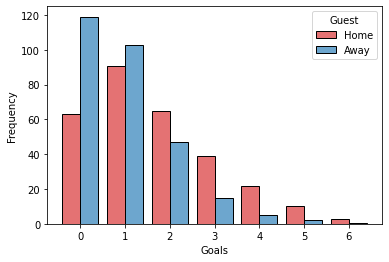

In [9]:
#Graph home and away
home = pd.DataFrame(df['Goals_home'])
home.insert(home.shape[1],'Guest', 'Home', True)
home.rename(columns={'Goals_home':'Goals'}, inplace=True)

away = pd.DataFrame(df['Goals_away'])
away.insert(away.shape[1],'Guest', 'Away', True)
away.rename(columns={'Goals_away':'Goals'}, inplace=True)

goals = pd.concat([home, away], axis=0, ignore_index=True)

my_pal = {"Home": "tab:red", "Away": "tab:blue"}
sns.histplot(data=goals, x='Goals', hue='Guest', stat='frequency', discrete=True, shrink=.8, alpha=0.65, multiple="dodge", palette=my_pal)
plt.savefig(r'img/goals_descriptive.png')

In [11]:
#Goals Summary
df[['Goals_home','Goals_away']].describe()

,Goals_home,Goals_away
count,583.000000,583.000000
mean,1.675815,0.943396
std,1.395703,1.039703
min,0.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,1.000000
75%,2.500000,1.000000
max,6.000000,6.000000


In [30]:
#Estimate pmf in each team
#I use ML, in poisson dist, the maximum likelihood to lambda is the mean
lambda_home = np.round(np.mean(df['Goals_home']),2)
lambda_away = np.round(np.mean(df['Goals_away']),2)

print(lambda_home, lambda_away)

#fit the poisson dist
home_dist = stats.poisson(lambda_home)
away_dist = stats.poisson(lambda_away)
x = np.arange(7)

1.68 0.94


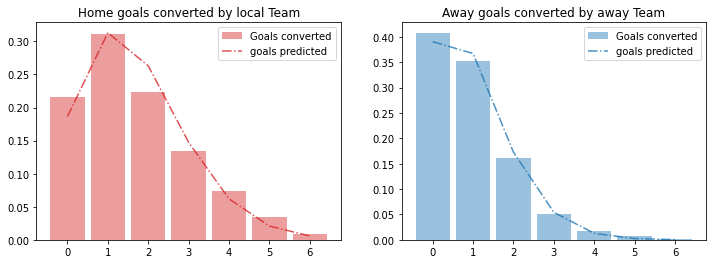

In [31]:
#graph both estimations
fig, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].hist(df['Goals_home'], bins=range(8), density=True, histtype='bar', align='left', orientation='vertical', rwidth=0.85, 
color="tab:red", alpha=0.45, label="Goals converted")
ax[0].plot(x, home_dist.pmf(x), ls='-.', color='tab:red', alpha=0.8, label="goals predicted")
ax[0].legend()
ax[0].title.set_text("Home goals converted by local Team")

ax[1].hist(df['Goals_away'], bins=range(8), density=True, histtype='bar', align='left', orientation='vertical', rwidth=0.85, 
color="tab:blue", alpha=0.45, label="Goals converted")
ax[1].plot(x, away_dist.pmf(x), ls='-.', color='tab:blue', alpha=0.8, label="goals predicted")
ax[1].legend()
ax[1].title.set_text("Away goals converted by away Team")

plt.savefig(r'img/goals_predictive.png')

Test de hipótesis para distribución Poisson

In [14]:
print('KStest for Chile:', stats.kstest(df['Goals_home'], home_dist.cdf))
print('KStest for Uruguay:', stats.kstest(df['Goals_away'], away_dist.cdf))
print(stats.ks_1samp(df['Goals_away'], away_dist.cdf))

KStest for Chile: KstestResult(statistic=0.28335875664325183, pvalue=6.54379921972344e-42)
KStest for Uruguay: KstestResult(statistic=0.3906278353585211, pvalue=1.218110572475791e-80)
KstestResult(statistic=0.3906278353585211, pvalue=1.218110572475791e-80)


con alpha > p-valor, se rechaza la hipótesis que los goles pueden ajustarse a una distribución Poisson

Crear modelo GLM Poisson

In [15]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [16]:
goals = pd.concat([df[['Team_home','Team_away','Goals_home']].assign(home=1).rename(columns={'Team_home':'Team', 'Team_away':'Opponent',
'Goals_home':'goals'}), df[['Team_home','Team_away','Goals_away']].assign(home=0).rename(columns={'Team_away':'Team', 'Team_home':'Opponent',
'Goals_away':'goals'})])

poisson_model = smf.glm(formula="goals ~ home + Team + Opponent", data=goals,family=sm.families.Poisson()).fit()
poisson_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                 1166
Model:                            GLM   Df Residuals:                     1146
Model Family:                 Poisson   Df Model:                           19
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1640.3
Date:                Mon, 21 Mar 2022   Deviance:                       1319.4
Time:                        18:21:44   Pearson chi2:                 1.17e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2221
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.2571      0.130     -1.983      0.047      -0.511      -0.003
Team[T.Bolivia]          -0.2707      0.112     -2.407      0.016      -0.491      -0.050
Team[T.Brazil]            0.1975      0.105      1.880      0.060      -0.008       0.404
Team[T.Chile]            -0.0950      0.106     -0.899      0.369      -0.302       0.112
Team[T.Colombia]         -0.2866      0.110     -2.597      0.009      -0.503      -0.070
Team[T.Ecuador]          -0.1685      0.107     -1.572      0.116      -0.379       0.042
Team[T.Paraguay]         -0.2856      0.111     -2.571      0.010      -0.503      -0.068
Team[T.Peru]             -0.3964      0.115     -3.435      0.001      -0.623      -0.170
Team[T.Uruguay]          -0.1424      0.107     -1.334      0.182      -0.352       0.067
Team[T.Venezuela]        -0.4407      0.118     -3.733      0.000      -0.672      -0.209
Opponent[T.Bolivia]       0.7567      0.119      6.338      0.000       0.523       0.991
Opponent[T.Brazil]       -0.2042      0.162     -1.260      0.208      -0.522       0.113
Opponent[T.Chile]         0.4241      0.127      3.339      0.001       0.175       0.673
Opponent[T.Colombia]      0.0572      0.136      0.420      0.675      -0.210       0.324
Opponent[T.Ecuador]       0.3121      0.129      2.413      0.016       0.059       0.566
Opponent[T.Paraguay]      0.3568      0.128      2.790      0.005       0.106       0.607
Opponent[T.Peru]          0.4972      0.124      4.001      0.000       0.254       0.741
Opponent[T.Uruguay]       0.3353      0.129      2.600      0.009       0.083       0.588
Opponent[T.Venezuela]     0.7269      0.119      6.085      0.000       0.493       0.961
home                      0.5751      0.053     10.787      0.000       0.471       0.680
=========================================================================================
"""

Predicción

In [23]:
def match_results(Team, Opponent):
    home_res = np.round(poisson_model.predict(pd.DataFrame(data={'Team': Team, 'Opponent': Opponent,'home':1},index=[1])),0)
    away_res = np.round(poisson_model.predict(pd.DataFrame(data={'Team': Opponent, 'Opponent': Team,'home':0},index=[1])),0)
    database.loc[(database.Team_home==Team)&(database.Team_away==Opponent)&(database.index.isin(index_na)),'Goals_home'] = home_res.values
    database.loc[(database.Team_home==Team)&(database.Team_away==Opponent)&(database.index.isin(index_na)),'Goals_away'] = away_res.values  
    return print(f'{Team} {home_res.values[0]:.0f} - {away_res.values[0]:.0f} {Opponent}')

In [24]:
match_results('Brazil', 'Argentina')
match_results('Uruguay', 'Peru')
match_results('Colombia', 'Bolivia')
match_results('Brazil', 'Chile')
match_results('Paraguay', 'Ecuador')
match_results('Argentina', 'Venezuela')
match_results('Peru', 'Paraguay')
match_results('Venezuela', 'Colombia')
match_results('Bolivia', 'Brazil')
match_results('Chile', 'Uruguay')
match_results('Ecuador', 'Argentina')

Brazil 2 - 1 Argentina
Uruguay 2 - 1 Peru
Colombia 2 - 1 Bolivia
Brazil 3 - 1 Chile
Paraguay 1 - 1 Ecuador
Argentina 3 - 0 Venezuela
Peru 1 - 1 Paraguay
Venezuela 1 - 1 Colombia
Bolivia 1 - 2 Brazil
Chile 2 - 1 Uruguay
Ecuador 1 - 1 Argentina


Tabla de posiciones final

In [26]:
positions = database[database['World Cup Qualif']==2022]

conditions = [positions['Goals_home']>positions['Goals_away'], positions['Goals_home']==positions['Goals_away'], positions['Goals_home']<positions['Goals_away']]
choices = [3, 1, 0]
positions['Home_points'] = np.select(conditions, choices)

conditions = [positions['Goals_away']>positions['Goals_home'], positions['Goals_home']==positions['Goals_away'], positions['Goals_away']<positions['Goals_home']]
positions['Away_points'] = np.select(conditions, choices)

positions['Goals_dif_home'] = positions['Goals_home'] - positions['Goals_away']
positions['Goals_dif_away'] = positions['Goals_away'] - positions['Goals_home']

In [27]:
positions = pd.concat([
    positions[['Team_home','Home_points','Goals_dif_home']].rename(columns={'Team_home':'Team', 'Home_points':'Points',
    'Goals_dif_home':'Goals dif'}), positions[['Team_away','Away_points','Goals_dif_away']].rename(columns={'Team_away':'Team', 
    'Away_points':'Points','Goals_dif_away':'Goals dif'})])

In [28]:
pos = positions.pivot_table(index="Team", values=['Points','Goals dif'], aggfunc=np.sum)
pos = pos.sort_values(by=['Points','Goals dif'], axis=0, ascending=False)
pos.reset_index(inplace=True)
pos.index = pos.index + 1
pos['Goals dif'] = pos['Goals dif'].astype('int32')
pos[['Team','Points','Goals dif']]

,Team,Points,Goals dif
1,Brazil,48,31
2,Argentina,39,18
3,Ecuador,27,10
4,Uruguay,25,-3
5,Chile,22,-2
6,Peru,22,-5
7,Colombia,21,-2
8,Bolivia,15,-14
9,Paraguay,15,-14
10,Venezuela,11,-19


- [Predict football results](https://github.com/dashee87/blogScripts/blob/master/Jupyter/2017-06-04-predicting-football-results-with-statistical-modelling.ipynb)
- [Stats models library](https://www.statsmodels.org/dev/glm.html)
- [Poisson Regression](https://online.stat.psu.edu/stat504/lesson/9)
- [Generalized linear models with examples](https://towardsdatascience.com/generalized-linear-models-9cbf848bb8ab)
- [opisthokonta.net](http://opisthokonta.net/?p=296)
- [Simulate normal models](https://paulminogue.com/index.php/2020/10/16/using-general-linear-models-to-simulate-gaelic-football-matches-in-python/)
- [how to get the positions table](https://developpaper.com/prediction-of-football-match-result-by-python-machine-learning/)
- [Poisson Distribution](https://www.sbo.net/strategy/football-prediction-model-poisson-distribution/)
- [Other stimation](http://pena.lt/y/2021/06/18/predicting-football-results-using-the-poisson-distribution/)